In [31]:
import warnings
warnings.filterwarnings('ignore')

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Lesson 4*
On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophiscated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifing common themes in customer reviews
* Discoverying the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model words
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics

## Part 1: Latent Dirchilet Allocation (LDA) Models
<a id="#p1"></a>

LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [2]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [3]:
titles = [t[:-4] for t in os.listdir(path)]

In [4]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token.lower() for token in simple_preprocess(text) if token not in STOPWORDS]

In [5]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [6]:
df = pd.DataFrame(index=titles)

In [7]:
df.head()

""
Austen_Emma0026
Austen_Emma0032
CBronte_Villette0086
CBronte_Jane0099
CBronte_Villette0092


In [8]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [9]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [10]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [11]:
df.head()

,author,book,section
Austen_Emma0026,1,Emma,26
Austen_Emma0032,1,Emma,32
CBronte_Villette0086,0,Villette,86
CBronte_Jane0099,0,Jane,99
CBronte_Villette0092,0,Villette,92


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [12]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

### Gensim LDA Topic Modeling

In [18]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [17]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.75)

In [16]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [17]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [19]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [20]:
topics = [' '.join(t[2:5]) for t in words]

## Part 3: Interpret LDA Results
<a id="#p3"></a>

### Topic Distance Visualization

In [23]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [24]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.058604 -0.031027       1        1  34.734283
10    -0.120414  0.005641       2        1  20.653625
3     -0.101455  0.039177       3        1  14.296436
14     0.026689  0.026194       4        1   5.501762
6      0.109678  0.052503       5        1   3.971548
0     -0.110039 -0.067808       6        1   3.434630
2     -0.134556 -0.075084       7        1   3.411023
13    -0.094378  0.013741       8        1   2.994616
9      0.109956 -0.027633       9        1   2.879962
4      0.136927 -0.074023      10        1   2.568011
1      0.060366  0.109875      11        1   1.894860
5     -0.120878  0.037209      12        1   1.239304
8      0.041421  0.032548      13        1   1.067612
12     0.041714  0.047221      14        1   0.730942
11     0.096366 -0.088533      15        1   0.621382, topic_info=     Category         Freq       Term        Total  loglift  logprob
992   Default  1536.000000       miss  1536.000000  30.0000  30.0000
1426  Default   612.000000  elizabeth   612.000000  29.0000  29.0000
77    Default   894.000000       emma   894.000000  28.0000  28.0000
2275  Default   678.000000     elinor   678.000000  27.0000  27.0000
2294  Default   568.000000   marianne   568.000000  26.0000  26.0000
745   Default   942.000000       jane   942.000000  25.0000  25.0000
377   Default  1337.000000       like  1337.000000  24.0000  24.0000
452   Default  1317.000000      think  1317.000000  23.0000  23.0000
568   Default   403.000000     madame   403.000000  22.0000  22.0000
120   Default   541.000000    harriet   541.000000  21.0000  21.0000
151   Default  1435.000000       know  1435.000000  20.0000  20.0000
71    Default   539.000000       door   539.000000  19.0000  19.0000
1052  Default   607.000000        sir   607.000000  18.0000  18.0000
1807  Default   393.000000      darcy   393.000000  17.0000  17.0000
1399  Default   304.000000     bennet   304.000000  16.0000  16.0000
465   Default   455.000000     weston   455.000000  15.0000  15.0000
221   Default   891.000000       room   891.000000  14.0000  14.0000
607   Default   928.000000      shall   928.000000  13.0000  13.0000
230   Default   574.000000     sister   574.000000  12.0000  12.0000
1792  Default   283.000000    bingley   283.000000  11.0000  11.0000
321   Default  1062.000000        day  1062.000000  10.0000  10.0000
802   Default   371.000000  rochester   371.000000   9.0000   9.0000
132   Default   760.000000      house   760.000000   8.0000   8.0000
380   Default   910.000000        man   910.000000   7.0000   7.0000
146   Default   630.000000       john   630.000000   6.0000   6.0000
392   Default   627.000000      night   627.000000   5.0000   5.0000
76    Default   399.000000      elton   399.000000   4.0000   4.0000
375   Default   615.000000       lady   615.000000   3.0000   3.0000
1405  Default   169.000000    collins   169.000000   2.0000   2.0000
160   Default   941.000000       long   941.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
1249  Topic15     4.259643      bread    73.464859   2.2334  -6.0363
1250  Topic15     6.214147  breakfast   142.784653   1.9465  -5.6587
1378  Topic15     9.992100     turned   335.298340   1.5678  -5.1837
431   Topic15     5.960150       seat   142.591248   1.9061  -5.7004
567   Topic15     9.784128       lucy   369.863373   1.4486  -5.2048
794   Topic15     4.493887        red    88.652328   2.0990  -5.9828
3615  Topic15     3.058518        bid    43.642811   2.4229  -6.3676
128   Topic15    10.799850       home   495.824158   1.2543  -5.1060
4718  Topic15     5.116051     bessie   125.059319   1.8846  -5.8532
122   Topic15     9.809703     having   540.337830   1.0722  -5.2022
748   Topic15     9.101050       knew   550.302185   0.9789  -5.2771
1719  Topic15     5.597055       paul   184.613159   1.5850  -5.7633
380

### Overall Model / Documents

In [25]:
distro = [lda[d] for d in corpus]

In [26]:
distro[0]

[(3, 0.40676975), (7, 0.14902122), (10, 0.44191673)]

In [27]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [28]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics

## Part 4: Selecting the Number of Topics
<a id="#p4"></a>

In [32]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

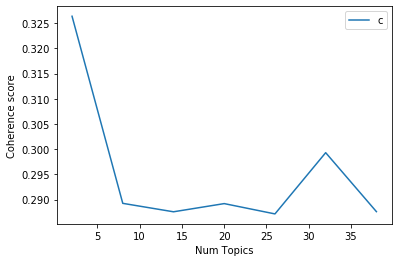

In [37]:
import matplotlib.pyplot as plt

# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3264
Num Topics = 8  has Coherence Value of 0.2893
Num Topics = 14  has Coherence Value of 0.2876
Num Topics = 20  has Coherence Value of 0.2892
Num Topics = 26  has Coherence Value of 0.2872
Num Topics = 32  has Coherence Value of 0.2993
Num Topics = 38  has Coherence Value of 0.2876


## Additional Resources
## Resources

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)